In [39]:
import re
import random
import pandas as pd
import hashlib

In [40]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [41]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
C# Basics,47.402339,1.529108,5.440777,31
Azure Private DNS,410.960576,21.629504,50.721296,19
RAG Project,565.556129,35.347258,102.136708,16
Azure AD Authentication,752.582171,57.890936,167.430666,13
Azure Functions + Visual Studio,806.893475,62.068729,274.146496,13
Audit Report Tracker (Sharepoint List),865.277679,78.661607,254.978939,11
Email Auth and Security,868.540031,72.378336,172.803026,12
WSL + Kali Linux,1141.699694,81.549978,363.102189,14
Azure DevOps Pipelines,1206.867015,46.417962,92.128113,26
Debugging in VS Code,1328.453151,73.802953,284.398525,18


# Histogram

sum of ages: ~45410.19


<Axes: >

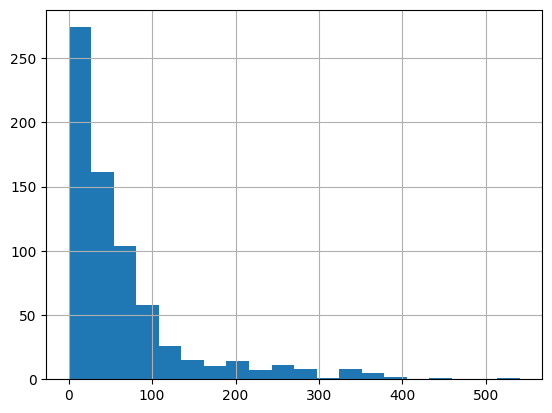

In [42]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [43]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [44]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [45]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [46]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [47]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [48]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [49]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [50]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [51]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 706
Total card age: 45410.19


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Open Source/GitHub,Downstream Repository\n\nA fork or clone of an...,31f044e0e9f013c3f84452e9d3446f43,-358.204687,-111.88964,358.204687,1790.234233,0.344839,0,0
1,Open Source/GitHub,Pull Request (PR)\n\nA request to merge change...,bb25e6d16d7859e745ba3cd98b4c570b,-149.165317,-111.88964,358.204687,1790.234233,0.344839,3,0
2,Open Source/GitHub,Label\n\nTags assigned to issues or pull reque...,e4d1c28705a30e9bf6d11964ef60133e,-128.573351,-111.88964,358.204687,1790.234233,0.344839,6,0
3,Open Source/GitHub,CONTRIBUTING.md\n\nA markdown file that outlin...,8c6bef283f652b590a091fef370fa432,-63.993058,-111.88964,358.204687,1790.234233,0.344839,9,0
4,Open Source/GitHub,Code of Conduct\n\nGuidelines that outline exp...,ad702a46ebc7800ed3db632a0a6fe3a9,-16.172484,-111.88964,358.204687,1790.234233,0.344839,12,0
5,Open Source/GitHub,GitHub Actions\n\nA feature on GitHub that all...,5281dc641160e7670129700c5b04176a,-5.918843,-111.88964,358.204687,1790.234233,0.344839,15,0
6,FSLogix,Q: What is the purpose of the Office 365 Conta...,976879cc4d77c846fbd4ebce93a2fec3,-331.468990,-101.41999,331.468990,2332.659762,0.098082,0,0
7,FSLogix,"Cloud Cache uses the concept of a proxy file, ...",78203bab9238f47ee752697bba4135a5,-199.751322,-101.41999,331.468990,2332.659762,0.098082,3,0
8,FSLogix,Q: How does FSLogix improve Office 365 perform...,f35dc0360cf624fcdfa25708f25b7398,-103.395411,-101.41999,331.468990,2332.659762,0.098082,6,0
9,FSLogix,Q: What is the main difference between FSLogix...,b36f546ea9eb5fbe3bb0e5f9c986e6fc,-82.545126,-101.41999,331.468990,2332.659762,0.098082,9,0


## Age Max

In [52]:
# n = 4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
## existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [53]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [54]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [55]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
14,Logging in Python,Q: What is one of the main disadvantages of us...,3753dbeb5ebfb4e424ec2fccd2df3557,-540.303080,-98.564476,540.303080,2168.418478,0.019576,0,0
165,Vocab,"Lost in a Good Book\nDoric columns: A simple, ...",7f5496b30d95587923948c9509df2835,-443.573524,-51.666410,443.573524,4598.310460,0.683898,0,0
97,PnP PowerShell,AppInv.aspx\nA SharePoint page used to grant a...,ffb4c4ea52b6951b0ba17c6ec30a0956,-400.635925,-68.282614,400.635925,4848.065596,0.536505,0,0
38,Powershell Modules,CurrentUser Scope\n\nDefinition: An installati...,f3d0d03320782899e1352f748fc1cda5,-395.388228,-91.563980,395.388228,4028.815131,0.672182,0,0
53,WSL + Kali Linux,WSLg (Windows Subsystem for Linux GUI)\nA feat...,69051af876862485bdb54d8c645a8a40,-363.102189,-81.549978,363.102189,1141.699694,0.503904,0,0
0,Open Source/GitHub,Downstream Repository\n\nA fork or clone of an...,31f044e0e9f013c3f84452e9d3446f43,-358.204687,-111.889640,358.204687,1790.234233,0.344839,0,0
327,PnP PowerShell,New-PnPList (PnP.PowerShell)\nCreates a new Sh...,9d9dc3700f5078d8eaff9507709eaacb,-355.727142,-68.282614,400.635925,4848.065596,0.536505,1,1
269,Powershell Modules,Auto-Import\n\nDefinition: A feature in PowerS...,6b1412630951dc5fee8ffa437ee0e0f2,-355.386496,-91.563980,395.388228,4028.815131,0.672182,1,1
22,Python,Q:\nWhich library is suggested for adding a pr...,20a08b1267d9ba7eb7b53e276cfdcc4c,-351.479186,-95.204361,351.479186,4474.604988,0.286026,0,0
139,Azure Developer Associate,Name two ways to visualize Azure Monitor metri...,12019d06f3f283c2eb56ccc8c9ffc6a5,-344.647007,-54.940282,344.647007,4285.342023,0.907486,0,0


In [56]:
existing_cards.head(10).sum()

head                   Open Source/GitHubOpen Source/GitHubOpen Sourc...
body                   Downstream Repository\n\nA fork or clone of an...
hash                   31f044e0e9f013c3f84452e9d3446f43bb25e6d16d7859...
age                                                         -1439.188589
subject_mean_age                                            -1077.017796
subject_highest_age                                          3475.104081
subject_age_sum                                              20072.04445
head_random_roll                                                2.461363
count                                                                 63
n_fold                                                                 0
dtype: object

In [57]:
existing_cards['age'].mean()

-64.3203856089754